# Linear Regression


Total subsets of size K: C(20,4) = 4845
IPFP iters=10000 | T col err∞=2.22e-16 | p match err∞=1.81e-01
  IPFP iters=10000 | T col err∞=2.22e-16 | p match err∞=1.81e-01

[Seed 0]  (K=4)
  Round 200/2000: FedOT=18.221214 | FedAvg(K)=35582.754701 | FedAvg(full)=16.618449
  Round 400/2000: FedOT=18.474736 | FedAvg(K)=34537.225339 | FedAvg(full)=16.604343
  Round 600/2000: FedOT=18.490043 | FedAvg(K)=36369.370395 | FedAvg(full)=16.604344
  Round 800/2000: FedOT=18.719715 | FedAvg(K)=35649.787099 | FedAvg(full)=16.604344
  Round 1000/2000: FedOT=18.508889 | FedAvg(K)=36074.286473 | FedAvg(full)=16.604344
  Round 1200/2000: FedOT=18.562890 | FedAvg(K)=35466.503093 | FedAvg(full)=16.604344
  Round 1400/2000: FedOT=18.642806 | FedAvg(K)=36194.426833 | FedAvg(full)=16.604344
  Round 1600/2000: FedOT=18.761087 | FedAvg(K)=35493.836020 | FedAvg(full)=16.604344
  Round 1800/2000: FedOT=18.845354 | FedAvg(K)=35516.168076 | FedAvg(full)=16.604344
  Round 2000/2000: FedOT=18.439061 | FedAvg(K)=35871.8

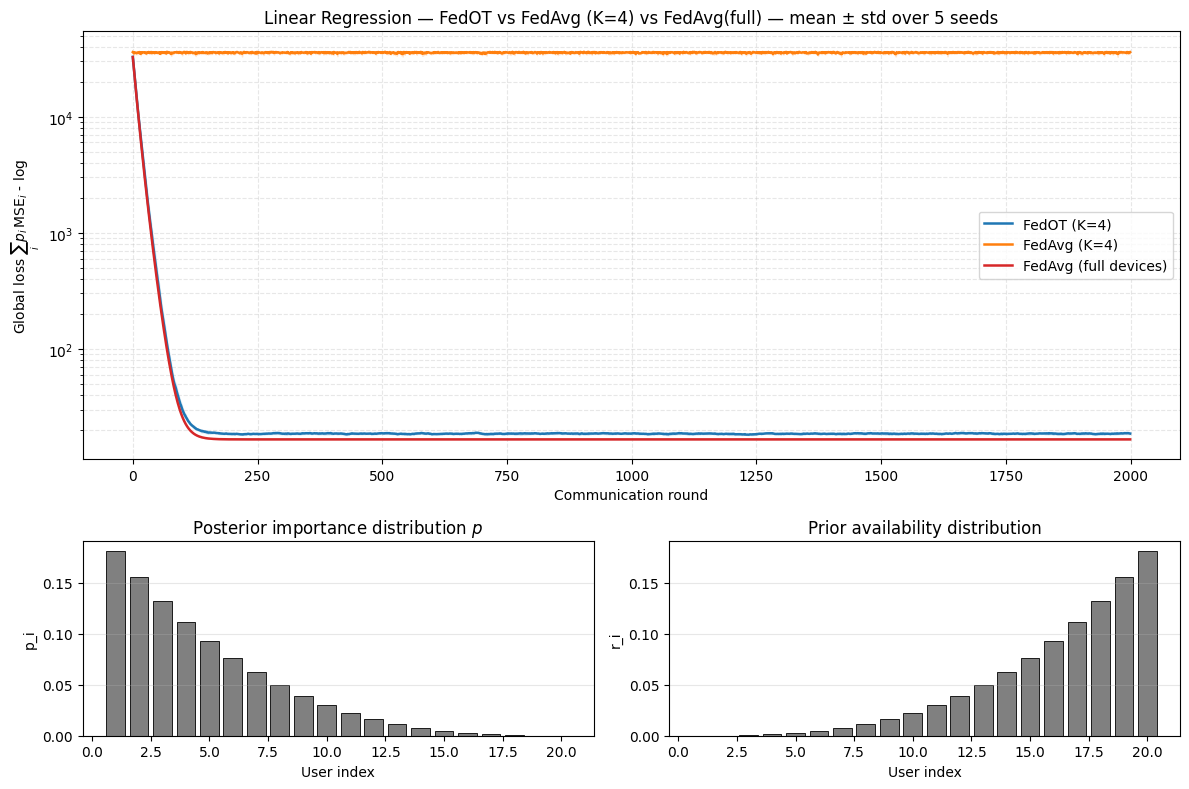

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# ================================================================
# Config (feel free to tweak)
# ================================================================
NUM_USERS = 20
K = 2               # <- generic subset size
ROUNDS = 2000               # make 2k if you want; 1k is faster to iterate
LOCAL_EPOCHS = 5            # local steps per selection
DIM = 100
SAMPLES_PER_USER = 3000 // NUM_USERS
LR = 0.01
SEEDS = [0, 1, 2, 3, 4]     # five seeds
NUM_SAMPLES_FOR_Q = 1_000_000   # Monte Carlo to estimate q over K-subsets

IPFP_TOL = 1e-12
IPFP_MAX_ITERS = 10000

# ================================================================
# Utilities: masked IPFP (unchanged in spirit, generalized for any K)
# ================================================================
def build_mask(n, subsets):
    """
    Boolean mask M (n x m) with 1-based subset entries:
    M[i, j] = True iff (i+1) is in subset j; rows are 0..n-1, subsets are tuples in {1,..,n}.
    """
    m = len(subsets)
    M = np.zeros((n, m), dtype=bool)
    for j, Aj in enumerate(subsets):
        for i in Aj:       # i is 1..n
            M[i-1, j] = True
    return M

def initialize_Y(p, q, M, mode="uniform"):
    n, m = M.shape
    Y = np.zeros((n, m), dtype=float)
    for j in range(m):
        rows = np.where(M[:, j])[0]
        if len(rows) == 0:
            if q[j] > 0:
                raise ValueError(f"Column j={j} has empty subset but q[j]={q[j]}>0.")
            else:
                continue
        if q[j] == 0.0:
            continue
        if mode == "uniform":
            Y[rows, j] = q[j] / len(rows)
        elif mode == "p_proportional":
            pj = p[rows]
            s = pj.sum()
            if s > 0:
                Y[rows, j] = q[j] * (pj / s)
            else:
                Y[rows, j] = q[j] / len(rows)
        else:
            raise ValueError("Unknown init mode")
    return Y

def ipfp_masked(p, q, M, tol=1e-10, max_iter=10000, verbose=False):
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)
    n, m = M.shape

    if p.ndim != 1 or q.ndim != 1:
        raise ValueError("p and q must be 1D arrays")
    if not np.all(p >= 0) or not np.all(q >= 0):
        raise ValueError("p and q must be nonnegative")
    if abs(p.sum() - q.sum()) > 1e-12:
        raise ValueError(f"Totals must match: sum(p)={p.sum()} vs sum(q)={q.sum()}")

    Y = initialize_Y(p, q, M, mode="uniform")
    rows_idx = [np.where(M[i, :])[0] for i in range(n)]
    cols_idx = [np.where(M[:, j])[0] for j in range(m)]

    for it in range(max_iter):
        # Row scaling
        row_sums = Y.sum(axis=1)
        with np.errstate(divide='ignore', invalid='ignore'):
            row_scale = np.ones(n)
            need = (row_sums > 0)
            row_scale[need] = p[need] / row_sums[need]
        infeasible_rows = (row_sums == 0) & (p > 0)
        if np.any(infeasible_rows):
            i = np.where(infeasible_rows)[0][0]
            raise ValueError(f"Infeasible: row i={i} has no support but p[i]={p[i]}>0")
        for i in range(n):
            js = rows_idx[i]
            if js.size:
                Y[i, js] *= row_scale[i]

        # Column scaling
        col_sums = Y.sum(axis=0)
        with np.errstate(divide='ignore', invalid='ignore'):
            col_scale = np.ones(m)
            needc = (col_sums > 0)
            col_scale[needc] = q[needc] / col_sums[needc]
        infeasible_cols = (col_sums == 0) & (q > 0)
        if np.any(infeasible_cols):
            j = np.where(infeasible_cols)[0][0]
            raise ValueError(f"Infeasible: column j={j} has no support but q[j]={q[j]}>0")
        for j in range(m):
            is_ = cols_idx[j]
            if is_.size:
                Y[is_, j] *= col_scale[j]

        row_err = np.linalg.norm(Y.sum(axis=1) - p, ord=1)
        col_err = np.linalg.norm(Y.sum(axis=0) - q, ord=1)
        if verbose and it % 100 == 0:
            print(f"[{it}] row_err={row_err:.3e}, col_err={col_err:.3e}")
        if max(row_err, col_err) <= tol:
            return Y, {"iters": it+1, "row_err": row_err, "col_err": col_err}

    return Y, {"iters": max_iter, "row_err": row_err, "col_err": col_err, "warning": "max_iter reached"}

def recover_T_from_Y(Y, q, M, p, strategy_for_q0="p_restricted"):
    n, m = Y.shape
    q = np.asarray(q, dtype=float)
    T = np.zeros_like(Y)

    pos = q > 0
    T[:, pos] = Y[:, pos] / q[pos]

    zero_cols = np.where(~pos)[0]
    for j in zero_cols:
        rows = np.where(M[:, j])[0]
        if rows.size == 0:
            raise ValueError(f"Column j={j} has empty subset; cannot define T.")
        if strategy_for_q0 == "p_restricted":
            w = p[rows]
            s = w.sum()
            if s > 0:
                T[rows, j] = w / s
            else:
                T[rows, j] = 1.0 / rows.size
        elif strategy_for_q0 == "uniform":
            T[rows, j] = 1.0 / rows.size
        else:
            raise ValueError("Unknown strategy_for_q0")

    T[~M] = 0.0
    col_sums = T.sum(axis=0)
    for j in range(m):
        if col_sums[j] != 0:
            T[:, j] /= col_sums[j]
    return T

def solve_T_with_given_subsets(p, q, subsets, tol=1e-10, max_iter=10000, verbose=False):
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)
    n = p.size
    m = len(subsets)
    if q.size != m:
        raise ValueError(f"Length of q ({q.size}) must equal number of subsets ({m}).")

    M = build_mask(n, subsets)  # 1-based subsets
    if abs(p.sum() - q.sum()) > 1e-12:
        p = p / p.sum()
        q = q / q.sum()

    Y, info = ipfp_masked(p, q, M, tol=tol, max_iter=max_iter, verbose=verbose)
    T = recover_T_from_Y(Y, q, M, p, strategy_for_q0="p_restricted")

    col_err = np.max(np.abs(T.sum(axis=0) - 1))
    recon_p = T @ q
    p_err = np.max(np.abs(recon_p - p))
    info.update({"T_col_err_inf": float(col_err), "p_match_err_inf": float(p_err)})
    return T, subsets, M, info

def column_users_and_weights(T, subsets, j):
    """
    Return (0-based user ids, normalized weights) for column j (subset of size K).
    """
    Aj_1 = subsets[j]                      # 1-based subset tuple
    rows = np.array([i-1 for i in Aj_1])   # to 0-based
    w = T[rows, j]
    s = w.sum()
    if s <= 0 or not np.isfinite(s):
        w = np.full_like(w, 1.0 / len(w))
    else:
        w = w / s
    return rows, w

# ================================================================
# Linear regression helpers
# ================================================================
def local_train_lr(X, y, w_init, epochs=1, lr=0.01):
    w = w_init.copy()
    n = len(y)
    for _ in range(epochs):
        preds = X @ w
        grad = (X.T @ (preds - y)) / n
        w -= lr * grad
    return w

def global_weighted_mse(w, user_data, p):
    tot = 0.0
    for i, (Xi, yi) in enumerate(user_data):
        preds = Xi @ w
        loss = mean_squared_error(yi, preds)
        tot += p[i] * loss
    return tot

# ================================================================
# Build skewed p, r and K-subsets; estimate q via Monte Carlo
# ================================================================
def make_skew_distributions(N):
    idx_1 = np.arange(1, N + 1, dtype=float)
    # r_i ∝ exp(+i) (prior for availability)
    r = np.power(idx_1, 3)
    r /= r.sum()
    # p_i ∝ exp(-i) (importance for objective)
    p = np.power(idx_1[::-1], 3)
    p /= p.sum()
    return p, r

def all_K_subsets_1based(N, K):
    return [tuple(c) for c in combinations(range(1, N + 1), K)]

def estimate_q_by_mc(subsets, r, N, K, num_samples=1_000_000, rng=None):
    """
    Estimate q over the provided 'subsets' (1-based tuples of size K)
    by Monte Carlo: S ~ Choice(N, K, p=r, replace=False).
    Efficiently tallies unique rows using np.unique.
    """
    if rng is None:
        rng = np.random.RandomState(0)
    # map subset tuple -> index
    subset_to_idx = {s: j for j, s in enumerate(subsets)}
    # sample many subsets
    draws = rng.choice(N, size=(num_samples, K), replace=True, p=r)
    draws.sort(axis=1)  # canonical order
    # convert to 1-based to match 'subsets'
    draws_1b = draws + 1
    # unique counts
    uniq, counts = np.unique(draws_1b, axis=0, return_counts=True)
    q_counts = np.zeros(len(subsets), dtype=np.int64)
    # assign counts to indices
    for row, c in zip(uniq, counts):
        tup = tuple(row.tolist())
        j = subset_to_idx.get(tup, None)
        if j is not None:
            q_counts[j] += c
    q = q_counts.astype(float)
    q /= q.sum()
    return q

# ================================================================
# Main experiment: FedOT(K) vs FedAvg(K, EXACT) vs FedAvg(full)
# ================================================================

all_losses_fedot = []
all_losses_faK   = []
all_losses_full  = []

# Generate data once (we'll use the same data for all seeds for fair comparison)
X_full, y_full = make_regression(n_samples=3000, n_features=DIM, noise=0.1, random_state=42)
X_full = StandardScaler().fit_transform(X_full)

# Partition to users
perm = np.random.permutation(len(X_full))
X = X_full[perm]
y = y_full[perm]
user_data = [
    (X[i * SAMPLES_PER_USER:(i + 1) * SAMPLES_PER_USER],
        y[i * SAMPLES_PER_USER:(i + 1) * SAMPLES_PER_USER])
    for i in range(NUM_USERS)
]

# Distributions and subset family
p, r = make_skew_distributions(NUM_USERS)
subsets_K = all_K_subsets_1based(NUM_USERS, K)
print(f"Total subsets of size K: C({NUM_USERS},{K}) = {len(subsets_K)}")

# Estimate q via Monte Carlo sampling from r
rng_init = np.random.RandomState(0)
q = estimate_q_by_mc(subsets_K, r, NUM_USERS, K, num_samples=NUM_SAMPLES_FOR_Q, rng=rng_init)

# Solve T via masked IPFP for this subset family and q
T, subsets_used, M_mask, info = solve_T_with_given_subsets(
    p, q, subsets_K, tol=IPFP_TOL, max_iter=IPFP_MAX_ITERS, verbose=False
)
print(f"IPFP iters={info.get('iters')} | T col err∞={info.get('T_col_err_inf'):.2e} | p match err∞={info.get('p_match_err_inf'):.2e}")

# --- Estimate q via Monte Carlo sampling from r ---
rng_init = np.random.RandomState(0)
q = estimate_q_by_mc(subsets_K, r, NUM_USERS, K, num_samples=NUM_SAMPLES_FOR_Q, rng=rng_init)

# --- Solve T via masked IPFP for this subset family and q ---
T, subsets_used, M_mask, info = solve_T_with_given_subsets(
    p, q, subsets_K, tol=IPFP_TOL, max_iter=IPFP_MAX_ITERS, verbose=False
)
print(f"  IPFP iters={info.get('iters')} | T col err∞={info.get('T_col_err_inf'):.2e} | p match err∞={info.get('p_match_err_inf'):.2e}")



for seed in SEEDS:
    
    print(f"\n[Seed {seed}]  (K={K})")
    rng = np.random.RandomState(seed)
    np.random.seed(seed)
    # --- Initialize globals for the three methods ---
    d = user_data[0][0].shape[1]
    w_fedot = np.zeros(d)
    w_faK   = np.zeros(d)
    w_full  = np.zeros(d)

    losses_ot   = []
    losses_faK  = []
    losses_full = []

    q_cum = np.cumsum(q)

    # --- Precompute local data references for speed ---
    Xs = [ud[0] for ud in user_data]
    ys = [ud[1] for ud in user_data]

    # --- Training loop ---
    for r_idx in range(ROUNDS):
        # sample a subset j ~ q
        u = rng.random()
        j = int(np.searchsorted(q_cum, u, side="right"))

        # members of subset j for this round
        users_S, weights_T = column_users_and_weights(T, subsets_used, j)  # length K

        # ------------------ FedOT(K) ------------------
        local_models_ot = []
        for uid in users_S:
            theta_i = local_train_lr(Xs[uid], ys[uid], w_fedot, epochs=LOCAL_EPOCHS, lr=LR)
            local_models_ot.append(theta_i)
        # convex combination by T column weights
        w_next_ot = np.zeros_like(w_fedot)
        for coeff, theta in zip(weights_T, local_models_ot):
            w_next_ot += coeff * theta
        w_fedot = w_next_ot
        losses_ot.append(global_weighted_mse(w_fedot, user_data, p))

        # ---------------- FedAvg(K), EXACT: sum_{i in S} (N/K)*p_i * theta_i ----------------
        local_models_faK = []
        for uid in users_S:
            theta_i = local_train_lr(Xs[uid], ys[uid], w_faK, epochs=LOCAL_EPOCHS, lr=LR)
            local_models_faK.append((uid, theta_i))
        w_next_faK = np.zeros_like(w_faK)
        scale = NUM_USERS / float(K)
        # pees = np.asarray(list(p[uid] for (uid, theta_i) in local_models_faK)).sum()
        # scale = pees
        for uid, theta_i in local_models_faK:
            w_next_faK += (p[uid] * scale) * theta_i
            # w_next_faK += (p[uid] / scale) * theta_i
        w_faK = w_next_faK
        losses_faK.append(global_weighted_mse(w_faK, user_data, p))

        # ---------------- FedAvg (full): sum_i p_i * theta_i ----------------
        local_models_full = []
        for uid in range(NUM_USERS):
            theta_i = local_train_lr(Xs[uid], ys[uid], w_full, epochs=LOCAL_EPOCHS, lr=LR)
            local_models_full.append((uid, theta_i))
        w_next_full = np.zeros_like(w_full)
        for uid, theta_i in local_models_full:
            w_next_full += p[uid] * theta_i
        w_full = w_next_full
        losses_full.append(global_weighted_mse(w_full, user_data, p))

        if (r_idx + 1) % 200 == 0:
            print(f"  Round {r_idx+1}/{ROUNDS}: FedOT={losses_ot[-1]:.6f} | "
                  f"FedAvg(K)={losses_faK[-1]:.6f} | FedAvg(full)={losses_full[-1]:.6f}")

    all_losses_fedot.append(np.array(losses_ot))
    all_losses_faK.append(np.array(losses_faK))
    all_losses_full.append(np.array(losses_full))

# ================================================================
# Aggregate across seeds
# ================================================================
all_losses_fedot = np.vstack(all_losses_fedot)
all_losses_faK   = np.vstack(all_losses_faK)
all_losses_full  = np.vstack(all_losses_full)

loss_fedot_mean = all_losses_fedot.mean(axis=0)
loss_fedot_std  = all_losses_fedot.std(axis=0)

loss_faK_mean = all_losses_faK.mean(axis=0)
loss_faK_std  = all_losses_faK.std(axis=0)

loss_full_mean = all_losses_full.mean(axis=0)
loss_full_std  = all_losses_full.std(axis=0)

# For the bar plots (use last-seed p and r — they are deterministic anyway)
p, r = make_skew_distributions(NUM_USERS)

# ================================================================
# Plot: loss curves + bars for p and r
# Colors: FedOT=blue, FedAvg(K)=orange, FedAvg(full)=red
# ================================================================
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[2.2, 1.0])

# --- (1) Loss curves (span top row) ---
ax0 = fig.add_subplot(gs[0, :])
x = np.arange(ROUNDS)

ax0.plot(x, loss_fedot_mean, label=f"FedOT (K={K})", color="tab:blue", linewidth=1.8)
ax0.fill_between(x, loss_fedot_mean - loss_fedot_std, loss_fedot_mean + loss_fedot_std,
                 alpha=0.15, color="tab:blue")

ax0.plot(x, loss_faK_mean, label=f"FedAvg (K={K})", color="tab:orange", linewidth=1.8)
ax0.fill_between(x, loss_faK_mean - loss_faK_std, loss_faK_mean + loss_faK_std,
                 alpha=0.15, color="tab:orange")

ax0.plot(x, loss_full_mean, label="FedAvg (full devices)", color="tab:red", linewidth=1.8)
ax0.fill_between(x, loss_full_mean - loss_full_std, loss_full_mean + loss_full_std,
                 alpha=0.15, color="tab:red")

ax0.set_yscale("log")  # optional
ax0.set_xlabel("Communication round")
ax0.set_ylabel(r"Global loss $\sum_i p_i \,\mathrm{MSE}_i$ - log")
ax0.set_title(f"Linear Regression — FedOT vs FedAvg (K={K}) vs FedAvg(full) — mean ± std over {len(SEEDS)} seeds")
ax0.grid(True, alpha=0.3, which="both", linestyle="--")
ax0.legend()

# --- (2) Bar plot for p ---
ax1 = fig.add_subplot(gs[1, 0])
ax1.bar(np.arange(1, NUM_USERS+1), p, color="gray", edgecolor="black", linewidth=0.6)
ax1.set_title("Posterior importance distribution $p$ ")
ax1.set_xlabel("User index")
ax1.set_ylabel("p_i")
ax1.grid(axis="y", alpha=0.3)

# --- (3) Bar plot for r ---
ax2 = fig.add_subplot(gs[1, 1])
ax2.bar(np.arange(1, NUM_USERS+1), r, color="gray", edgecolor="black", linewidth=0.6)
ax2.set_title("Prior availability distribution")
ax2.set_xlabel("User index")
ax2.set_ylabel("r_i")
ax2.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig(f"linreg_K{K}_FedOT_vs_FedAvg_full_with_priors.png", dpi=300, bbox_inches="tight")
plt.savefig(f"linreg_K{K}_FedOT_vs_FedAvg_full_with_priors.pdf", bbox_inches="tight")
plt.show()

# MNIST

In [ ]:
# ================================================================
# FedOT vs FedAvg(K) vs FedAvg(full) on Adult Dataset (Generic K, Monte Carlo q from r)
# Colors: FedOT=blue, FedAvg(K)=orange, FedAvg(full)=red
# ================================================================
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from itertools import combinations
from sklearn.preprocessing import StandardScaler, LabelEncoder
from ucimlrepo import fetch_ucirepo
import pandas as pd

# -----------------------------
# Experiment Configuration
# -----------------------------
NUM_USERS = 100
NUM_CLASSES = 2  # Binary classification for Adult dataset
K = 2
ROUNDS = 1000
LOCAL_EPOCHS = 3
TOTAL_SAMPLES = 3000
SAMPLES_PER_USER = TOTAL_SAMPLES // NUM_USERS
LR = 0.1
SEEDS = [0, 1, 2, 3, 4]
IPFP_TOL = 1e-10
IPFP_MAX_ITERS = 4000
NUM_SAMPLES_FOR_Q = 1_000_000

# Fetch Adult dataset
print("Loading Adult dataset...")
adult = fetch_ucirepo(id=2)

# Get features and targets
X = adult.data.features
y = adult.data.targets

# metadata
print(adult.metadata)
print(adult.variables)

# Save original X for later analysis
X_orig = X.copy()

# Handle categorical features in X
categorical_columns = X.select_dtypes(include=['object']).columns
print(f"Categorical columns: {list(categorical_columns)}")

for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Convert features to numpy array
X_full = X.values

# Process labels - Adult dataset has income column
y_column = y.columns[0]
print(f"Target column: {y_column}")
print(f"Original unique labels: {y[y_column].unique()}")

# Encode labels to 0/1
y_full = (y[y_column] == '>50K').astype(int).values
print(f"Encoded labels: {np.unique(y_full)}")

# Update DIM based on actual features
DIM = X_full.shape[1]
print(f"Dataset shape: {X_full.shape}")
print(f"Feature dimension (DIM): {DIM}")
print(f"Number of classes: {NUM_CLASSES}")

# Standardize features
X_full = StandardScaler().fit_transform(X_full)

# Take subset
X_full = X_full[:TOTAL_SAMPLES]
y_full = y_full[:TOTAL_SAMPLES]
print(f"Using {TOTAL_SAMPLES} samples")

# ================================================================
# Masked IPFP on an arbitrary K-subset family (1-based subset tuples)
# ================================================================
def build_mask(n, subsets):
    m = len(subsets)
    M = np.zeros((n, m), dtype=bool)
    for j, Aj in enumerate(subsets):
        for i in Aj:       # i in 1..n
            M[i-1, j] = True
    return M

def initialize_Y(p, q, M, mode="uniform"):
    n, m = M.shape
    Y = np.zeros((n, m), dtype=float)
    for j in range(m):
        rows = np.where(M[:, j])[0]
        if len(rows) == 0:
            if q[j] > 0:
                raise ValueError(f"Column j={j} has empty subset but q[j]={q[j]}>0.")
            else:
                continue
        if q[j] == 0.0:
            continue
        if mode == "uniform":
            Y[rows, j] = q[j] / len(rows)
        elif mode == "p_proportional":
            pj = p[rows]
            s = pj.sum()
            if s > 0:
                Y[rows, j] = q[j] * (pj / s)
            else:
                Y[rows, j] = q[j] / len(rows)
        else:
            raise ValueError("Unknown init mode")
    return Y

def ipfp_masked(p, q, M, tol=1e-10, max_iter=10000, verbose=False):
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)
    n, m = M.shape
    if p.ndim != 1 or q.ndim != 1:
        raise ValueError("p and q must be 1D arrays")
    if not np.all(p >= 0) or not np.all(q >= 0):
        raise ValueError("p and q must be nonnegative")
    if abs(p.sum() - q.sum()) > 1e-12:
        raise ValueError(f"Totals must match: sum(p)={p.sum()} vs sum(q)={q.sum()}")

    Y = initialize_Y(p, q, M, mode="uniform")
    rows_idx = [np.where(M[i, :])[0] for i in range(n)]
    cols_idx = [np.where(M[:, j])[0] for j in range(m)]

    for it in range(max_iter):
        # Row scaling
        row_sums = Y.sum(axis=1)
        with np.errstate(divide='ignore', invalid='ignore'):
            row_scale = np.ones(n)
            need = (row_sums > 0)
            row_scale[need] = p[need] / row_sums[need]
        infeasible_rows = (row_sums == 0) & (p > 0)
        if np.any(infeasible_rows):
            i = np.where(infeasible_rows)[0][0]
            raise ValueError(f"Infeasible: row i={i} has no support but p[i]={p[i]}>0")
        for i in range(n):
            js = rows_idx[i]
            if js.size:
                Y[i, js] *= row_scale[i]

        # Column scaling
        col_sums = Y.sum(axis=0)
        with np.errstate(divide='ignore', invalid='ignore'):
            col_scale = np.ones(m)
            needc = (col_sums > 0)
            col_scale[needc] = q[needc] / col_sums[needc]
        infeasible_cols = (col_sums == 0) & (q > 0)
        if np.any(infeasible_cols):
            j = np.where(infeasible_cols)[0][0]
            raise ValueError(f"Infeasible: column j={j} has no support but q[j]={q[j]}>0")
        for j in range(m):
            is_ = cols_idx[j]
            if is_.size:
                Y[is_, j] *= col_scale[j]

        row_err = np.linalg.norm(Y.sum(axis=1) - p, ord=1)
        col_err = np.linalg.norm(Y.sum(axis=0) - q, ord=1)
        if verbose and it % 200 == 0:
            print(f"[{it}] row_err={row_err:.3e}, col_err={col_err:.3e}")
        if max(row_err, col_err) <= tol:
            return Y, {"iters": it+1, "row_err": row_err, "col_err": col_err}

    return Y, {"iters": max_iter, "row_err": row_err, "col_err": col_err, "warning": "max_iter reached"}

def recover_T_from_Y(Y, q, M, p, strategy_for_q0="p_restricted"):
    n, m = Y.shape
    q = np.asarray(q, dtype=float)
    T = np.zeros_like(Y)

    pos = q > 0
    T[:, pos] = Y[:, pos] / q[pos]

    zero_cols = np.where(~pos)[0]
    for j in zero_cols:
        rows = np.where(M[:, j])[0]
        if rows.size == 0:
            raise ValueError(f"Column j={j} has empty subset; cannot define T.")
        if strategy_for_q0 == "p_restricted":
            w = p[rows]
            s = w.sum()
            if s > 0:
                T[rows, j] = w / s
            else:
                T[rows, j] = 1.0 / rows.size
        elif strategy_for_q0 == "uniform":
            T[rows, j] = 1.0 / rows.size
        else:
            raise ValueError("Unknown strategy_for_q0")

    T[~M] = 0.0
    col_sums = T.sum(axis=0)
    for j in range(m):
        if col_sums[j] != 0:
            T[:, j] /= col_sums[j]
    return T

def solve_T_with_given_subsets(p, q, subsets, tol=1e-10, max_iter=10000, verbose=False):
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)
    n = p.size
    m = len(subsets)
    if q.size != m:
        raise ValueError(f"Length of q ({q.size}) must equal number of subsets ({m}).")

    M = build_mask(n, subsets)  # 1-based
    if abs(p.sum() - q.sum()) > 1e-12:
        p = p / p.sum()
        q = q / q.sum()

    Y, info = ipfp_masked(p, q, M, tol=tol, max_iter=max_iter, verbose=verbose)
    T = recover_T_from_Y(Y, q, M, p, strategy_for_q0="p_restricted")

    col_err = np.max(np.abs(T.sum(axis=0) - 1))
    recon_p = T @ q
    p_err = np.max(np.abs(recon_p - p))
    info.update({"T_col_err_inf": float(col_err), "p_match_err_inf": float(p_err)})
    return T, subsets, M, info

def column_users_and_weights(T, subsets, j):
    Aj_1 = subsets[j]                      # 1-based subset tuple
    rows = np.array([i-1 for i in Aj_1])   # to 0-based indices
    w = T[rows, j]
    s = w.sum()
    if s <= 0 or not np.isfinite(s):
        w = np.full_like(w, 1.0 / len(w))
    else:
        w = w / s
    return rows, w

# ================================================================
# Distributions and subset family helpers
# ================================================================
def make_skew_distributions(N):
    idx_1 = np.arange(1, N + 1, dtype=float)
    # r_i ∝ exp(+i) (availability prior)
    r = np.ones(N)
    r /= r.sum()
    # p_i ∝ exp(-i) (importance)
    p = np.power(idx_1[::-1], 4)
    p /= p.sum()
    print(r)
    print(p)
    return p, r

def all_K_subsets_1based(N, K):
    return [tuple(c) for c in combinations(range(1, N + 1), K)]

def estimate_q_by_mc(subsets, r, N, K, num_samples=1_000_000, rng=None):
    if rng is None:
        rng = np.random.RandomState(0)
    subset_to_idx = {s: j for j, s in enumerate(subsets)}
    draws = rng.choice(N, size=(num_samples, K), replace=True, p=r)
    draws.sort(axis=1)
    draws_1b = draws + 1
    uniq, counts = np.unique(draws_1b, axis=0, return_counts=True)
    q_counts = np.zeros(len(subsets), dtype=np.int64)
    for row, c in zip(uniq, counts):
        tup = tuple(row.tolist())
        j = subset_to_idx.get(tup, None)
        if j is not None:
            q_counts[j] += c
    q = q_counts.astype(float)
    q /= q.sum()
    return q

# ================================================================
# Multinomial logistic regression (NumPy)
# ================================================================
def init_theta(d, C):
    return {"W": np.zeros((d, C)), "b": np.zeros(C)}

def softmax(z):
    z = z - np.max(z, axis=1, keepdims=True)
    e = np.exp(z)
    return e / np.sum(e, axis=1, keepdims=True)

def forward(X, theta):
    return X @ theta["W"] + theta["b"]

def ce_loss_and_grad(X, y, theta, l2=0.0):
    n, d = X.shape
    C = theta["W"].shape[1]
    scores = forward(X, theta)
    P = softmax(scores)
    Y = np.zeros((n, C))
    Y[np.arange(n), y] = 1.0
    eps = 1e-12
    loss = -np.sum(Y * np.log(P + eps)) / n
    loss += 0.5 * l2 * np.sum(theta["W"] ** 2)
    G = (P - Y) / n
    dW = X.T @ G + l2 * theta["W"]
    db = np.sum(G, axis=0)
    return loss, {"W": dW, "b": db}

def local_train(theta, X, y, epochs=1, lr=0.1, l2=0.0):
    th = {"W": theta["W"].copy(), "b": theta["b"].copy()}
    for _ in range(epochs):
        _, grads = ce_loss_and_grad(X, y, th, l2=l2)
        th["W"] -= lr * grads["W"]
        th["b"] -= lr * grads["b"]
    return th

def weighted_average_thetas(thetas, weights):
    W = np.sum([w * t["W"] for t, w in zip(thetas, weights)], axis=0)
    b = np.sum([w * t["b"] for t, w in zip(thetas, weights)], axis=0)
    return {"W": W, "b": b}

def global_loss(theta, user_data, p, l2=0.0):
    tot = 0.0
    for i, (Xi, yi) in enumerate(user_data):
        li, _ = ce_loss_and_grad(Xi, yi, theta, l2=l2)
        tot += p[i] * li
    return tot

# ================================================================
# Data partitioning
# ================================================================
def make_user_data(X_full, y_full, N):
    perm = np.random.permutation(len(X_full))
    X = X_full[perm]
    y = y_full[perm]
    return [(X[i*SAMPLES_PER_USER:(i+1)*SAMPLES_PER_USER],
             y[i*SAMPLES_PER_USER:(i+1)*SAMPLES_PER_USER]) for i in range(N)]

# ================================================================
# Setup before training loop
# ================================================================
all_losses_fedot = []
all_losses_faK   = []
all_losses_full  = []

# Create user data once
user_data = make_user_data(X_full, y_full, NUM_USERS)

# skewed p and r
p, r = make_skew_distributions(NUM_USERS)

# K-subsets and q via Monte Carlo from r
subsets_K = all_K_subsets_1based(NUM_USERS, K)
print(f"Total subsets size K: C({NUM_USERS},{K}) = {len(subsets_K)}")

# Estimate q once
rng_init = np.random.RandomState(0)
q = estimate_q_by_mc(subsets_K, r, NUM_USERS, K, num_samples=NUM_SAMPLES_FOR_Q, rng=rng_init)

# Solve T for this family
T, subsets_used, M_mask, info = solve_T_with_given_subsets(
    p, q, subsets_K, tol=IPFP_TOL, max_iter=IPFP_MAX_ITERS, verbose=False
)
print(f"IPFP iters={info.get('iters')} | T col err∞={info.get('T_col_err_inf'):.2e} | p match err∞={info.get('p_match_err_inf'):.2e}")

# ================================================================
# Training loop over seeds
# ================================================================
for seed in SEEDS:
    print(f"\n[Seed {seed}]  (K={K})")
    rng = np.random.RandomState(seed)
    np.random.seed(seed)

    # initialize global models
    theta_fedot = init_theta(DIM, NUM_CLASSES)
    theta_faK   = init_theta(DIM, NUM_CLASSES)
    theta_full  = init_theta(DIM, NUM_CLASSES)

    losses_ot, losses_faK, losses_full = [], [], []

    # Precompute for speed
    Xs = [ud[0] for ud in user_data]
    ys = [ud[1] for ud in user_data]
    q_cum = np.cumsum(q)

    for t in range(ROUNDS):
        # sample subset j ~ q
        u = rng.random()
        j = int(np.searchsorted(q_cum, u, side="right"))
        users_S, weights_T = column_users_and_weights(T, subsets_used, j)

        # ------------------ FedOT(K) ------------------
        local_thetas = []
        for uid in users_S:
            ti = local_train(theta_fedot, Xs[uid], ys[uid], epochs=LOCAL_EPOCHS, lr=LR, l2=0.0)
            local_thetas.append(ti)
        theta_fedot = weighted_average_thetas(local_thetas, weights_T)
        losses_ot.append(global_loss(theta_fedot, user_data, p, l2=0.0))

        # ---------------- FedAvg(K) EXACT ----------------
        local_thetas_fak = []
        for uid in users_S:
            ti = local_train(theta_faK, Xs[uid], ys[uid], epochs=LOCAL_EPOCHS, lr=LR, l2=0.0)
            local_thetas_fak.append((uid, ti))
        scale = NUM_USERS / float(K)
        W_acc = np.zeros_like(theta_faK["W"])
        b_acc = np.zeros_like(theta_faK["b"])
        for uid, ti in local_thetas_fak:
            coeff = p[uid] * scale
            W_acc += coeff * ti["W"]
            b_acc += coeff * ti["b"]
        theta_faK = {"W": W_acc, "b": b_acc}
        losses_faK.append(global_loss(theta_faK, user_data, p, l2=0.0))

        # ---------------- FedAvg (full) ----------------
        W_acc = np.zeros_like(theta_full["W"])
        b_acc = np.zeros_like(theta_full["b"])
        for uid in range(NUM_USERS):
            ti = local_train(theta_full, Xs[uid], ys[uid], epochs=LOCAL_EPOCHS, lr=LR, l2=0.0)
            W_acc += p[uid] * ti["W"]
            b_acc += p[uid] * ti["b"]
        theta_full = {"W": W_acc, "b": b_acc}
        losses_full.append(global_loss(theta_full, user_data, p, l2=0.0))

        if (t + 1) % 200 == 0:
            print(f"  round {t+1}/{ROUNDS}  FedOT={losses_ot[-1]:.4f} | "
                  f"FedAvg(K)={losses_faK[-1]:.4f} | FedAvg(full)={losses_full[-1]:.4f}")

    all_losses_fedot.append(np.array(losses_ot))
    all_losses_faK.append(np.array(losses_faK))
    all_losses_full.append(np.array(losses_full))

# ================================================================
# Aggregate and plot (loss curves + p/r bars)
# ================================================================
L_ot   = np.vstack(all_losses_fedot)
L_faK  = np.vstack(all_losses_faK)
L_full = np.vstack(all_losses_full)

mean_ot,  std_ot  = L_ot.mean(axis=0),  L_ot.std(axis=0)
mean_faK, std_faK = L_faK.mean(axis=0), L_faK.std(axis=0)
mean_full,std_full= L_full.mean(axis=0), L_full.std(axis=0)

# p and r (deterministic functions of N)
p, r = make_skew_distributions(NUM_USERS)

fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 2, height_ratios=[2.2, 1.0])

# --- Top row: loss curves
ax0 = fig.add_subplot(gs[0, :])
x = np.arange(ROUNDS)

# FedOT (blue)
ax0.plot(x, mean_ot, label=f"FedOT (K={K})", color="tab:blue", linewidth=1.8)
ax0.fill_between(x, mean_ot - std_ot, mean_ot + std_ot, alpha=0.15, color="tab:blue")

# FedAvg(K) (orange)
ax0.plot(x, mean_faK, label=f"FedAvg (K={K})", color="tab:orange", linewidth=1.8)
ax0.fill_between(x, mean_faK - std_faK, mean_faK + std_faK, alpha=0.15, color="tab:orange")

# FedAvg (full) (red)
ax0.plot(x, mean_full, label="FedAvg (full devices)", color="tab:red", linewidth=1.8)
ax0.fill_between(x, mean_full - std_full, mean_full + std_full, alpha=0.15, color="tab:red")

# ax0.set_yscale("log")  # optional
ax0.set_xlabel("Communication round")
ax0.set_ylabel(r"Global loss $\sum_i p_i f_i(\theta)$")
ax0.set_title(f"MNIST — FedOT vs FedAvg (K={K}) vs FedAvg(full) — mean ± std over {len(SEEDS)} seeds")
ax0.grid(True, alpha=0.3, which="both", linestyle="--")
ax0.legend()

# --- Bottom left: p bar plot
ax1 = fig.add_subplot(gs[1, 0])
ax1.bar(np.arange(1, NUM_USERS+1), p, color="gray", edgecolor="black", linewidth=0.6)
ax1.set_title("Posterior Importance Distribution $p$")
ax1.set_xlabel("User index")
ax1.set_ylabel("p_i")
ax1.grid(axis="y", alpha=0.3)

# --- Bottom right: r bar plot
ax2 = fig.add_subplot(gs[1, 1])
ax2.bar(np.arange(1, NUM_USERS+1), r, color="gray", edgecolor="black", linewidth=0.6)
ax2.set_title("Prior User Selection Probability Marginals")
ax2.set_xlabel("User index")
ax2.set_ylabel("r_i")
ax2.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig(f"mnist_K{K}_FedOT_vs_FedAvg_full_with_priors.png", dpi=300, bbox_inches="tight")
plt.savefig(f"mnist_K{K}_FedOT_vs_FedAvg_full_with_priors.pdf", bbox_inches="tight")
plt.show()

{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the fol

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 784 is different from 100)